In [1]:
library(mcompanion)
library(pracma)

# Functions

In [2]:
singularValues <- function(A){
    eigs <- eigen(t(A) %*% A)$values 
    return(sqrt(eigs[eigs > 0]))
}

In [3]:
SVD <- function(A){
    sV <- singularValues(A)
    sigma <- diag(sV, nrow = dim(A)[1], ncol = dim(A)[2])
    
    V <- eigen(t(A) %*% A)$vectors
    
    U <- A %*% V[, 1] / sV[1]
    for(i in 2:length(sV)){
        U <- cbind(U, A %*% V[, i] / sV[i])
    }  
    U <- cbind(U, null_complement(U))
    
    return(list('U' = U, 'Sigma' = sigma, 'V' = V))
    
}

# Data

In [4]:
trainInput <- t(read.csv('trainInput.csv', header=F))
trainOutput <- c(read.csv('trainOutput.csv', header=F))
testInput <- t(read.csv('testInput.csv', header=F))
testOutput <- c(read.csv('testOutput.csv', header=F))

In [5]:
digits <- unique(trainOutput)

digitTrain <- list()
for(i in 1:length(digits)){
    digitTrain[[i]] <- na.omit(as.matrix(trainInput[trainOutput == digits[[i]],]))
}
names(digitTrain) <- digits

# Display train data

In [6]:
displayImage <- function(im){
    rotate <- function(x) t(apply(x, 2, rev))
    im <- matrix(im, sqrt(length(im)), sqrt(length(im)), byrow=T)
    image(rotate(im), useRaster=TRUE, axes=FALSE, col = grey(seq(1, 0, length = 256)))
}

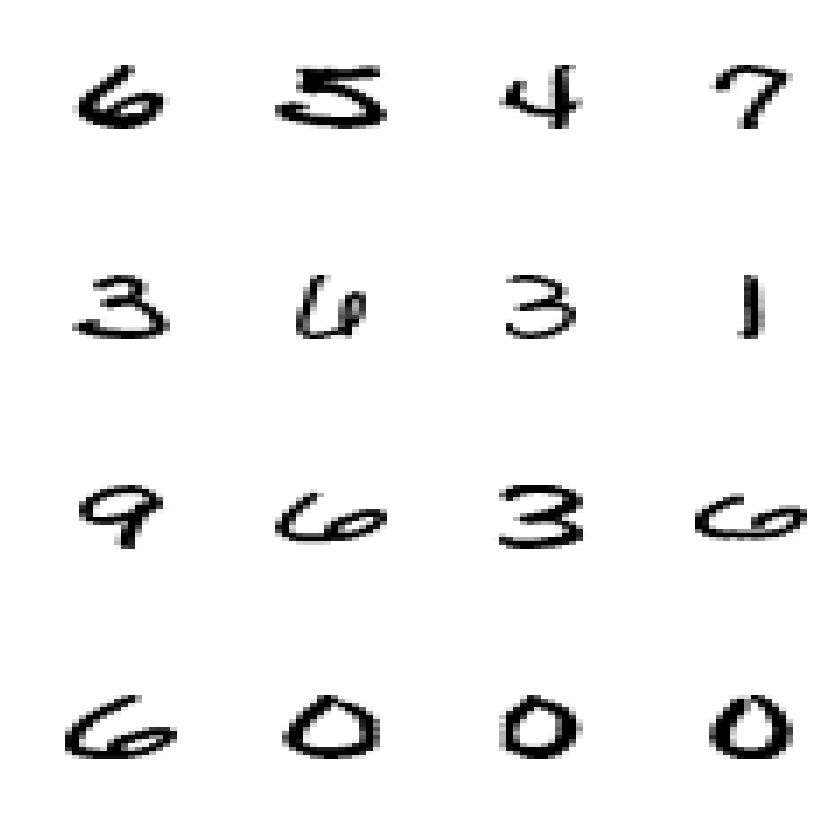

In [7]:
par(mfrow=c(4,4))
for(i in 1:8){
    displayImage(trainInput[i,])
}
for(i in 1:8){
    displayImage(testInput[i,])
}

# Singular images

In [8]:
displaySingularImage <- function(digit, imageNumber=1){
    im <- SVD(digitTrain[[toString(digit)]])$V
    im <- im[, imageNumber]
    displayImage(im)
}

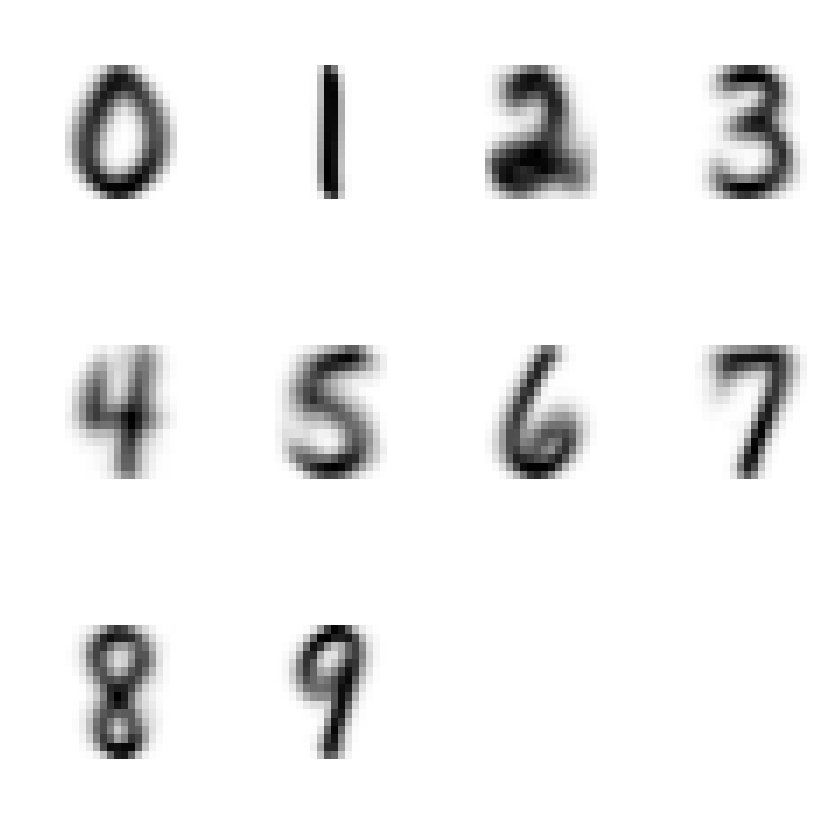

In [9]:
par(mfrow=c(3,4))
for(i in 0:9){
    displaySingularImage(i)
}

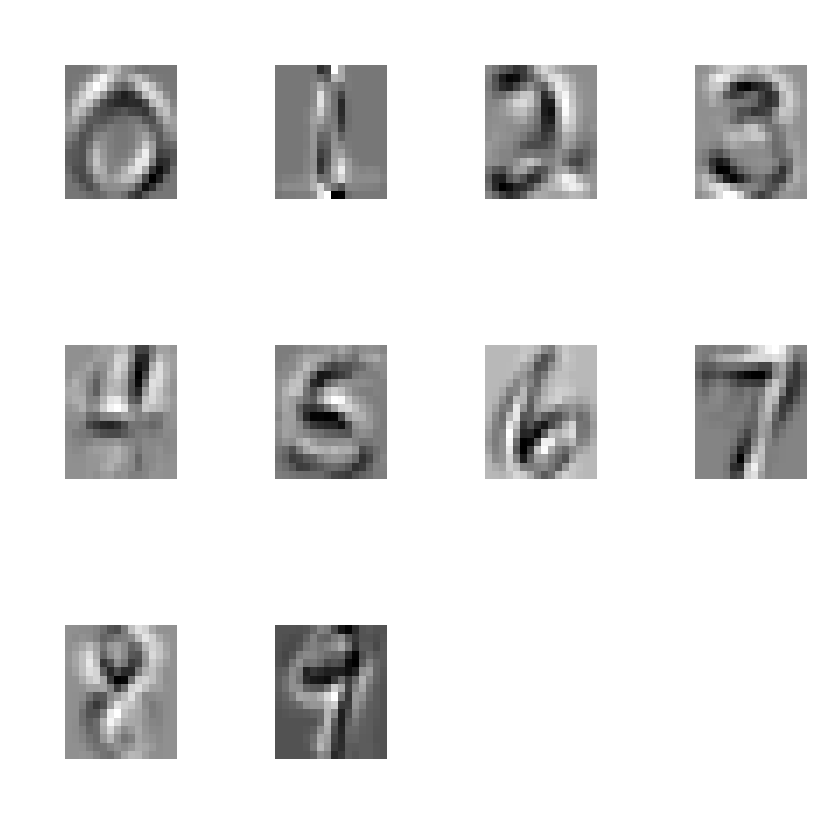

In [10]:
par(mfrow=c(3,4))
for(i in 0:9){
    displaySingularImage(i, 5)
}

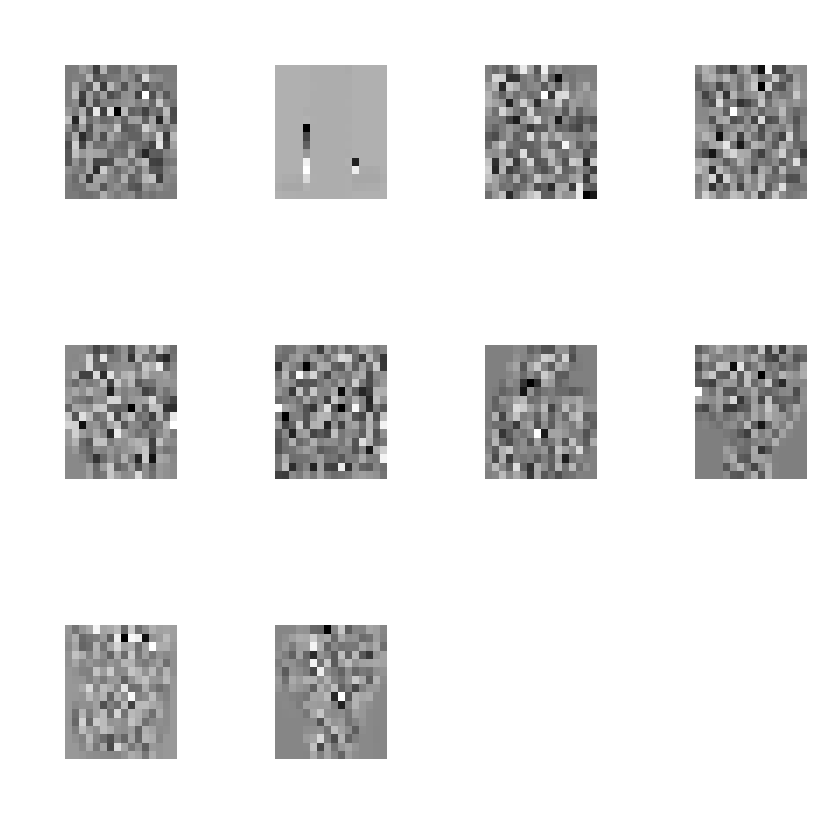

In [11]:
par(mfrow=c(3,4))
for(i in 0:9){
    displaySingularImage(i, 100)
}

# Least Squares

In [12]:
dot <- function(x, y){
  sum(x * y)
}

norm2 <- function(x) {
  sqrt(dot(x, x))
}

xHat <- function(A, b) {
  inv(t(A) %*% A) %*% t(A) %*% b
}

error <- function(A,x,b) {
  norm2(A %*% x - b)
}

leastSquaresError <- function(X, y) {
  y <- as.matrix(y)
  X <- as.matrix(X)
  sol <- xHat(X, y)
  return(error(X, sol, y))
}

# Training model


In [13]:
model <- list()

for(i in 1:length(digits)){
    model[[i]] <- SVD(digitTrain[[toString(digits[i])]])$V[,1:20]
}
names(model) <- digits

In [14]:
predict <- function(y){
    errors <- c()
    for(i in digits){
        errors <- c(errors, leastSquaresError(model[[toString(i)]], y))
    }
    return(digits[which(errors == min(errors))])
}

# Testing model

In [15]:
predictions <- c()
for(i in 1:nrow(testInput)){
    predictions <- c(predictions, predict(testInput[i,]))
}

In [16]:
names <- unlist(digits)
names <- sort(names)
names <- lapply(names, toString)

## Confusion matrix

In [17]:
confusion <- function(i,j){
    return(sum(predictions[testOutput==i] == j))
}

In [18]:
confusionMatrix <- matrix(, nrow = length(digits), ncol = length(digits))

rownames(confusionMatrix) <- names
colnames(confusionMatrix) <- names

In [19]:
for(i in names){
    for(j in names){
        confusionMatrix[[i,j]] <- confusion(i,j)
    }   
}

rownames - actual  
colnames - predicted

In [20]:
dimnames(confusionMatrix) <- list(actual=rownames(confusionMatrix), predicted=colnames(confusionMatrix))

ftable(confusionMatrix, row.vars='actual', col.vars='predicted')

       predicted   0   1   2   3   4   5   6   7   8   9
actual                                                  
0                355   0   2   0   1   0   0   0   0   1
1                  0 259   0   0   3   0   2   0   0   0
2                  8   1 179   2   3   0   0   1   4   0
3                  1   0   4 148   1   8   0   1   2   1
4                  1   1   0   0 187   1   1   3   0   6
5                  8   1   2   4   0 140   0   0   2   3
6                  2   0   0   0   2   2 164   0   0   0
7                  0   1   1   0   3   0   0 139   0   3
8                  4   0   2   6   0   1   0   0 149   4
9                  0   1   0   1   4   0   0   4   1 166

## Accuracy for each digit

### Precision

In [21]:
precision <- c()
for(i in names){
    precision <- c(precision, confusionMatrix[i,i] / sum(confusionMatrix[i,]))
}

for(i in 1:length(names)){
    cat(cat('For digit', names[[i]], 'precision score is', precision[i]), '.\n', sep='')
}

For digit 0 precision score is 0.9888579.
For digit 1 precision score is 0.9810606.
For digit 2 precision score is 0.9040404.
For digit 3 precision score is 0.8915663.
For digit 4 precision score is 0.935.
For digit 5 precision score is 0.875.
For digit 6 precision score is 0.9647059.
For digit 7 precision score is 0.9455782.
For digit 8 precision score is 0.8975904.
For digit 9 precision score is 0.9378531.


### Recall

In [22]:
recall <- c()
for(i in names){
    recall <- c(recall, confusionMatrix[i,i] / sum(confusionMatrix[,i]))
}

for(i in 1:length(names)){
    cat(cat('For digit', names[[i]], 'recall score is', recall[i]), '.\n', sep='')
}

For digit 0 recall score is 0.9366755.
For digit 1 recall score is 0.9810606.
For digit 2 recall score is 0.9421053.
For digit 3 recall score is 0.9192547.
For digit 4 recall score is 0.9166667.
For digit 5 recall score is 0.9210526.
For digit 6 recall score is 0.9820359.
For digit 7 recall score is 0.9391892.
For digit 8 recall score is 0.943038.
For digit 9 recall score is 0.9021739.


### F1

In [23]:
f1 <- 2 * precision * recall / (precision + recall)

for(i in 1:length(names)){
    cat(cat('For digit', names[[i]], 'F1 score is', f1[i]), '.\n', sep='')
}

For digit 0 F1 score is 0.9620596.
For digit 1 F1 score is 0.9810606.
For digit 2 F1 score is 0.9226804.
For digit 3 F1 score is 0.9051988.
For digit 4 F1 score is 0.9257426.
For digit 5 F1 score is 0.8974359.
For digit 6 F1 score is 0.9732938.
For digit 7 F1 score is 0.9423729.
For digit 8 F1 score is 0.9197531.
For digit 9 F1 score is 0.9196676.


## Overall	correct	classification	rate

In [24]:
sum(diag(confusionMatrix)) / sum(confusionMatrix) * 100

[1] 93.9711